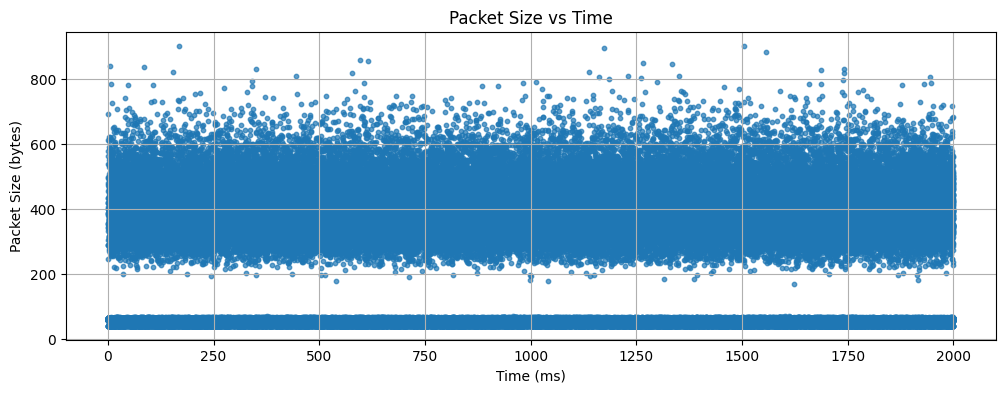

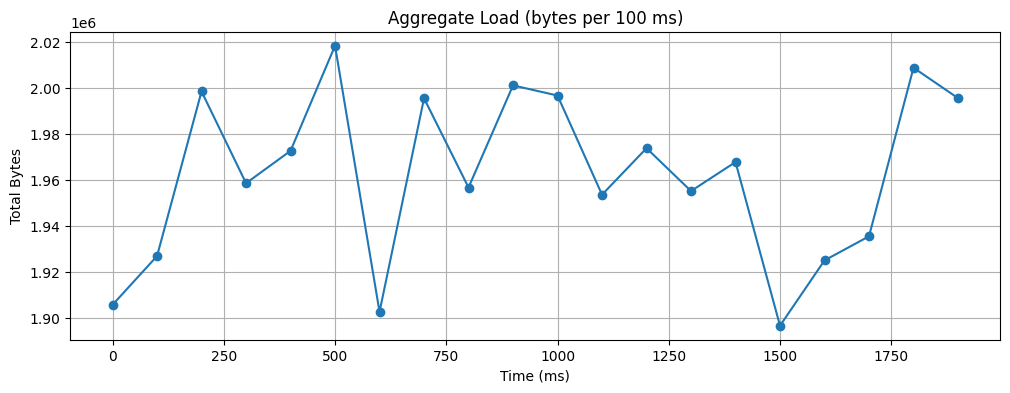

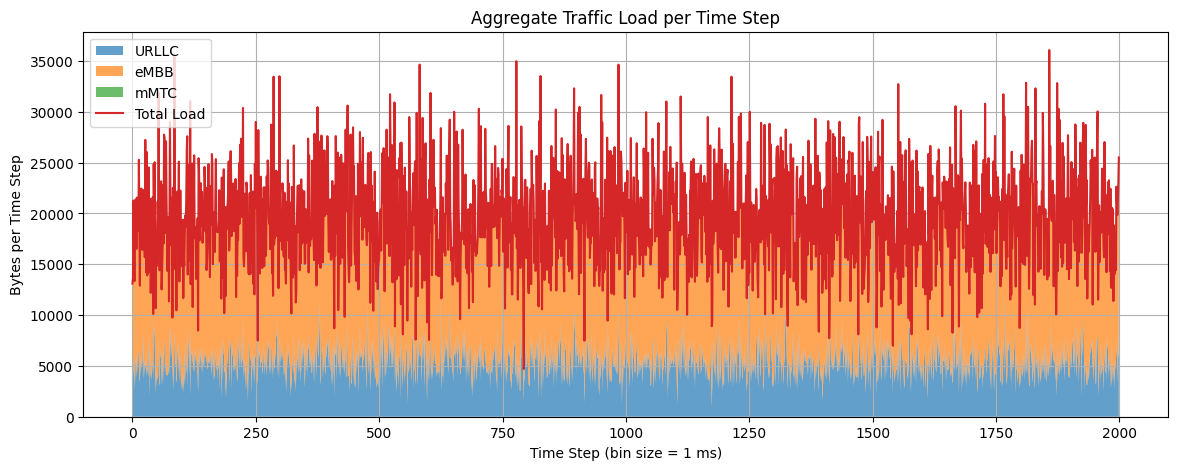

In [2]:
# ctmc_overlap_traffic.py
# Continuous-Time Markov Chain (CTMC) traffic generator with machine overlaps.
# - CTMC over states: S0 (idle), S1, S12, S2, S23, S3
# - Active UEs per state drive which machines generate packets
# - Per-slice interarrivals: URLLC=Erlang, eMBB=Lognormal, mMTC=Weibull
# - Per-UE packet sizes: normal/lognormal/discrete (from machines_config)
# - Outputs: per-UE CSVs, all_traces.csv, timeline CSVs, and basic plots

import math
import random
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ===============================
# Reproducibility & Horizon
# ===============================
np.random.seed(11)
random.seed(11)
SIM_DURATION_MS = 2_000_000  # total simulation time in milliseconds

# ===============================
# CTMC: states and transition rates Q[state][next] = rate
# Tune these to control average dwell/overlap time.
# ===============================
states = ["S0", "S1", "S12", "S2", "S23", "S3"]
# Q: Dict[str, Dict[str, float]] = {
#     "S0":  {"S1": 0.4},
#     #"S1":  {"S12": 0.15, "S2": 0.25},
#     "S1":  {"S12": 0.20, "S2": 0.25},
#     "S12": {"S2": 0.35},
#     #"S2":  {"S23": 0.12, "S3": 0.22},
#     "S2":  {"S23": 0.20, "S3": 0.22},
#     "S23": {"S3": 0.25},
#     "S3":  {"S0": 0.1},  # loop back to idle
# }

# Q = {
#     "S0":  {"S1": 0.60},                     # was 0.40  → enter activity sooner
#     "S1":  {"S12": 0.40, "S2": 0.35},        # was 0.15/0.25 → more likely to hit eMBB
#     "S12": {"S2": 0.20},                     # was 0.35 → longer dwell in eMBB overlap
#     "S2":  {"S23": 0.08, "S3": 0.12},        # was 0.12/0.22 → longer dwell in core eMBB
#     "S23": {"S3": 0.18},                     # was 0.25 → longer dwell in eMBB overlap
#     "S3":  {"S0": 0.20},                     # was 0.06 → leave non-eMBB faster
# }


Q = {
    "S0": {"S1": 0.2},
    "S1": {"S12": 0.1, "S2": 0.05},
    "S12": {"S2": 0.1},
    "S2": {"S23": 0.05, "S3": 0.03},
    "S23": {"S3": 0.05},
    "S3": {"S0": 0.02},
}


# ===============================
# Map each state -> active machines (UEs)
# Adjust to include/exclude machines in an overlap.
# ===============================
state_activity: Dict[str, List[str]] = {
    "S0":  [],
    "S1":  ["M1"],          # only machining
    "S12": ["M1", "M2"],    # machining+assembly overlap
    "S2":  ["M2"],          # assembly
    "S23": ["M2", "M3"],    # assembly+inspection overlap
    "S3":  ["M3"],          # inspection
}

# ===============================
# UE/Machine catalog (packet sizes)
# Keep/add UEs as needed; only M1..M3 are activated above by default.
# ===============================
# machines_config = [
#     {"name": "M1", "slice": "URLLC", "dist": "normal",    "mean": 60,  "std": 5,  "ip": "10.0.0.1"},
#     {"name": "M2", "slice": "eMBB",  "dist": "lognormal", "mean": 6.0, "std": 0.5,"ip": "10.0.0.2"},
#     {"name": "M3", "slice": "mMTC",  "dist": "discrete",  "values": [20,40,60,100], "probs": [0.4,0.3,0.2,0.1], "ip": "10.0.0.3"},
# ]

machines_config = [
    {"name": "M1", "slice": "URLLC", "dist": "normal", "mean": 60, "std": 2 ,   "ip": "10.0.0.1"},  # smaller std
    {"name": "M2", "slice": "eMBB",  "dist": "lognormal", "mean": 6.0, "std": 0.2, "ip": "10.0.0.2"},
    {"name": "M3", "slice": "mMTC",  "dist": "discrete", "values": [40,60], "probs": [0.7,0.3], "ip": "10.0.0.3"},
]


machines_by_name = {m["name"]: m for m in machines_config}

# ===============================
# Per-slice interarrival distributions (ms)
# URLLC -> Erlang(k, scale=mean/k)
# eMBB  -> Lognormal(mu, sigma) in log-space
# mMTC  -> Weibull(shape k, scale lambda)
# Tune to hit target loads.
# ===============================
interarrival_cfg = {
    "URLLC": {"dist": "erlang",    "k": 3, "mean_ms": 1.5},
    "eMBB":  {"dist": "lognormal", "mu": math.log(7.0), "sigma": 0.55},
    "mMTC":  {"dist": "weibull",   "k": 1.5, "scale": 120.0},
}

# ===============================
# Direction mix (UL vs DL) per slice
# ===============================
uplink_ratio = {
    "URLLC": 0,
    "eMBB":  0,
    "mMTC":  0,
}
SERVER_IP = "192.168.0.1"


# ===============================
# Sampling helpers
# ===============================
def sample_packet_size(m: Dict) -> float:
    d = m["dist"]
    if d == "normal":
        return float(max(1.0, np.random.normal(m["mean"], m["std"])))
    if d == "lognormal":
        return float(np.random.lognormal(mean=m["mean"], sigma=m["std"]))
    if d == "discrete":
        return float(np.random.choice(m["values"], p=m["probs"]))
    raise ValueError(f"Unknown size dist: {d}")

def sample_interarrival_ms_for_slice(slice_type: str) -> float:
    cfg = interarrival_cfg[slice_type]
    if cfg["dist"] == "erlang":
        k = cfg["k"]
        scale = cfg["mean_ms"] / k
        return float(np.random.gamma(shape=k, scale=scale))
    if cfg["dist"] == "lognormal":
        return float(np.random.lognormal(mean=cfg["mu"], sigma=cfg["sigma"]))
    if cfg["dist"] == "weibull":
        return float(cfg["scale"] * np.random.weibull(cfg["k"]))
    raise ValueError(f"Unknown interarrival dist for slice {slice_type}")

def sample_direction(machine_ip: str, slice_type: str):
    if random.random() < uplink_ratio[slice_type]:
        return "UL", machine_ip, SERVER_IP
    else:
        return "DL", SERVER_IP, machine_ip


# ===============================
# CTMC simulation
# ===============================
def simulate_ctmc(Q: Dict[str, Dict[str, float]], start_state: str, t_end: float) -> List[Tuple[str, float, float]]:
    """
    Simulate CTMC path until t_end.
    Returns list of segments (state, start_ms, end_ms).
    """
    timeline: List[Tuple[str, float, float]] = []
    state = start_state
    t = 0.0

    while t < t_end:
        rates = Q.get(state, {})
        if not rates:
            timeline.append((state, t, t_end))
            break

        total = sum(rates.values())
        dwell = np.random.exponential(1.0 / total)
        seg_end = min(t + dwell, t_end)
        timeline.append((state, t, seg_end))
        t = seg_end
        if t >= t_end:
            break

        next_states = list(rates.keys())
        probs = np.array([rates[s] / total for s in next_states], dtype=float)
        state = np.random.choice(next_states, p=probs)

    return timeline

def extract_activity_intervals(timeline: List[Tuple[str, float, float]],
                               state_activity: Dict[str, List[str]]) -> Dict[str, List[Tuple[float, float]]]:
    """
    Build { UE_name: [(start_ms, end_ms), ...] } from CTMC segments.
    """
    intervals: Dict[str, List[Tuple[float, float]]] = {}
    for st, t0, t1 in timeline:
        for ue in state_activity.get(st, []):
            intervals.setdefault(ue, []).append((t0, t1))
    return intervals

def generate_packets(intervals: Dict[str, List[Tuple[float, float]]]) -> List[Dict]:
    """
    For each UE and its active intervals, simulate a renewal arrival process and packet sizes.
    """
    rows = []
    for ue, spans in intervals.items():
        m = machines_by_name.get(ue)
        if not m:
            continue
        slice_type = m["slice"]
        for (start_ms, end_ms) in spans:
            t = start_ms
            while True:
                t += sample_interarrival_ms_for_slice(slice_type)
                if t > end_ms:
                    break
                size = sample_packet_size(m)
                direction, src, dst = sample_direction(m["ip"], slice_type)
                rows.append({
                    "Time": round(t, 3),
                    "machine": ue,
                    "slice": slice_type,
                    "direction": direction,
                    "Source": src,
                    "Destination": dst,
                    "Length": round(size, 2),
                })
    return rows


# ===============================
# Main
# ===============================
def main():
    # 1) CTMC path
    timeline = simulate_ctmc(Q, start_state="S0", t_end=SIM_DURATION_MS)

    # 2) Active intervals per UE
    activity = extract_activity_intervals(timeline, state_activity)

    # 3) Generate packets
    packet_rows = generate_packets(activity)
    trace_df = pd.DataFrame(packet_rows).sort_values(["Time", "machine"]).reset_index(drop=True)

    # 4) Save outputs
    timeline_df = pd.DataFrame(timeline, columns=["state", "start_ms", "end_ms"])
    intervals_df = pd.DataFrame(
        [{"machine": ue, "start_ms": a, "end_ms": b} for ue, spans in activity.items() for (a, b) in spans]
    )
    
    # ✅ Convert ms → sec
    for df in [timeline_df, intervals_df, trace_df]:
        for col in df.columns:
            if col.endswith("_ms") or col == "Time":
                df[col] = df[col] / 1000.0

    timeline_df.to_csv("ctmc_timeline_sec_mp.csv", index=False)
    intervals_df.to_csv("ue_activity_intervals_sec_mp.csv", index=False)
    trace_df.to_csv("all_traces_sec_mp.csv", index=False)

    for (slice_type, machine), grp in trace_df.groupby(["slice", "machine"]):
        grp.to_csv(f"{slice_type}_{machine}_trace_sec_mp.csv", index=False)

    # 5) Quick plots (matplotlib, one figure per chart, no explicit colors)
    if not trace_df.empty:
        # Packet size vs time
        plt.figure(figsize=(12, 4))
        plt.scatter(trace_df["Time"], trace_df["Length"], s=10, alpha=0.7)
        plt.title("Packet Size vs Time")
        plt.xlabel("Time (ms)")
        plt.ylabel("Packet Size (bytes)")
        plt.grid(True)
        plt.show()

        # Aggregate load per 100 ms
        bin_ms = 100.0
        trace_df["time_bin"] = (trace_df["Time"] // bin_ms) * bin_ms
        agg = trace_df.groupby("time_bin")["Length"].sum().sort_index()
        plt.figure(figsize=(12, 4))
        plt.plot(agg.index, agg.values, marker="o")
        plt.title(f"Aggregate Load (bytes per {int(bin_ms)} ms)")
        plt.xlabel("Time (ms)")
        plt.ylabel("Total Bytes")
        plt.grid(True)
        plt.show()

        # Stacked area per slice (1 ms bins)
        bin_ms = 1.0
        trace_df["time_bin_sa"] = (trace_df["Time"] // bin_ms).astype(int)
        pivot = trace_df.pivot_table(
            index="time_bin_sa", columns="slice", values="Length",
            aggfunc="sum", fill_value=0
        ).sort_index()
        # ensure columns exist
        for s in ["URLLC", "eMBB", "mMTC"]:
            if s not in pivot.columns:
                pivot[s] = 0.0
        pivot["Total"] = pivot[["URLLC", "eMBB", "mMTC"]].sum(axis=1)

        plt.figure(figsize=(14, 5))
        plt.stackplot(pivot.index, pivot["URLLC"], pivot["eMBB"], pivot["mMTC"],
                      labels=["URLLC", "eMBB", "mMTC"], alpha=0.7)
        plt.plot(pivot.index, pivot["Total"], linewidth=1.5, label="Total Load")
        plt.title("Aggregate Traffic Load per Time Step")
        plt.xlabel("Time Step (bin size = 1 ms)")
        plt.ylabel("Bytes per Time Step")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("No packets generated (check rates/interarrival parameters).")

if __name__ == "__main__":
    main()


In [3]:
# ===== Plot each machine's traffic separately =====
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_per_machine(trace_df: pd.DataFrame, outdir: str = "plots", bin_ms: float = 100.0, show: bool = False):
    """
    Makes separate figures for each machine:
      1) Packet size vs time (scatter)
      2) Bytes per time bin
      3) UL vs DL stacked per time bin (+ total line)
      4) Interarrival histogram (empirical)
      5) Packet size histogram
    Saves PNGs into `outdir`. If show=True, also displays them.
    """
    Path(outdir).mkdir(parents=True, exist_ok=True)

    # Ensure expected columns exist
    required_cols = {"Time", "Length", "machine", "direction"}
    missing = required_cols - set(trace_df.columns)
    if missing:
        raise ValueError(f"trace_df missing columns: {missing}")

    for m in sorted(trace_df["machine"].unique()):
        dfm = trace_df[trace_df["machine"] == m].copy()
        if dfm.empty:
            continue

        # 1) Packet size vs time
        fig = plt.figure(figsize=(10, 3.8))
        plt.scatter(dfm["Time"], dfm["Length"], s=10, alpha=0.7)
        plt.title(f"{m} • Packet Size vs Time")
        plt.xlabel("Time (ms)")
        plt.ylabel("Packet Size (bytes)")
        plt.grid(True)
        fig.savefig(os.path.join(outdir, f"{m}_size_vs_time.png"), dpi=150, bbox_inches="tight")
        if show: plt.show()
        plt.close(fig)

        # 2) Bytes per time bin
        dfm["time_bin"] = (dfm["Time"] // bin_ms) * bin_ms
        agg = dfm.groupby("time_bin")["Length"].sum().sort_index()
        fig = plt.figure(figsize=(10, 3.8))
        plt.plot(agg.index, agg.values, marker="o")
        plt.title(f"{m} • Bytes per {int(bin_ms)} ms")
        plt.xlabel("Time (ms)")
        plt.ylabel("Total Bytes")
        plt.grid(True)
        fig.savefig(os.path.join(outdir, f"{m}_bytes_per_{int(bin_ms)}ms.png"), dpi=150, bbox_inches="tight")
        if show: plt.show()
        plt.close(fig)

        # 3) UL vs DL stacked per time bin (+ total)
        pivot = dfm.pivot_table(
            index="time_bin", columns="direction", values="Length",
            aggfunc="sum", fill_value=0
        ).sort_index()
        for col in ["UL", "DL"]:
            if col not in pivot.columns:
                pivot[col] = 0.0
        total = pivot["UL"] + pivot["DL"]

        fig = plt.figure(figsize=(10, 3.8))
        plt.stackplot(pivot.index, pivot["UL"], pivot["DL"], labels=["UL", "DL"], alpha=0.7)
        plt.plot(pivot.index, total.values, linewidth=1.2, label="Total")
        plt.title(f"{m} • UL/DL Split per {int(bin_ms)} ms")
        plt.xlabel("Time (ms)")
        plt.ylabel("Bytes per Bin")
        plt.legend()
        plt.grid(True)
        fig.savefig(os.path.join(outdir, f"{m}_ULDL_per_{int(bin_ms)}ms.png"), dpi=150, bbox_inches="tight")
        if show: plt.show()
        plt.close(fig)

        # 4) Interarrival histogram (empirical)
        t_sorted = np.sort(dfm["Time"].values)
        if len(t_sorted) >= 2:
            inter = np.diff(t_sorted)
            fig = plt.figure(figsize=(10, 3.8))
            plt.hist(inter, bins=50)
            plt.title(f"{m} • Interarrival Times (empirical)")
            plt.xlabel("Δt (ms)")
            plt.ylabel("Count")
            plt.grid(True)
            fig.savefig(os.path.join(outdir, f"{m}_interarrival_hist.png"), dpi=150, bbox_inches="tight")
            if show: plt.show()
            plt.close(fig)

        # 5) Packet size histogram
        fig = plt.figure(figsize=(10, 3.8))
        plt.hist(dfm["Length"].values, bins=50)
        plt.title(f"{m} • Packet Size Histogram")
        plt.xlabel("Packet Size (bytes)")
        plt.ylabel("Count")
        plt.grid(True)
        fig.savefig(os.path.join(outdir, f"{m}_pkt_size_hist.png"), dpi=150, bbox_inches="tight")
        if show: plt.show()
        plt.close(fig)

    print(f"Saved per-machine plots to: {outdir}")

# ---- Usage ----
# Option A: if you already have trace_df in memory from the simulation:
#plot_per_machine(trace_df, outdir="plots_per_machine", bin_ms=100, show=False)

# Option B: from the saved CSV:
df = pd.read_csv("all_traces_sec_mp.csv")
plot_per_machine(df, outdir="plots_per_machine", bin_ms=100, show=False)


Saved per-machine plots to: plots_per_machine


In [4]:
import random
import pandas as pd


trace_df = pd.read_csv("all_traces_sec_mp.csv")

# 1. Build global time axis using all unique times
time_axis = pd.Series(sorted(trace_df["Time"].unique()))

# 2. Per-machine alignment
for (slice_type, machine), group in trace_df.groupby(["slice", "machine"]):
    # Use time as index
    df = group.set_index("Time").sort_index()

    # Reindex to global axis (preserves fractional times)
    df = df.reindex(time_axis)

    # Restore time column
    df = df.reset_index().rename(columns={"index": "Time"})

    # Fill fixed columns
    df["machine"] = machine
    df["slice"] = slice_type

    # Fill Length: NaN → 0
    df["Length"] = df["Length"].fillna(0)

    # Fill direction: keep real values, randomize only when missing
    directions = ["UL", "DL"]
    df["direction"] = df.apply(
        lambda row: row["direction"] if pd.notna(row["direction"]) 
        else random.choice(directions),
        axis=1
    )

    # Fill IPs: keep real, assign when missing
    machine_ip = machines_config[[m["name"] for m in machines_config].index(machine)]["ip"]
    server_ip = "192.168.0.1"
    def assign_ips(row):
        if pd.notna(row["Source"]) and pd.notna(row["Destination"]):
            return row["Source"], row["Destination"]
        if row["direction"] == "UL":
            return machine_ip, server_ip
        else:
            return server_ip, machine_ip

    df[["Source", "Destination"]] = df.apply(assign_ips, axis=1, result_type="expand")

    # Save aligned CSV
    fname = f"{slice_type}_{machine}_aligned_trace_sec_mp.csv"
    df.to_csv(fname, index=False)
    print(f"Saved {fname} with {len(df)} rows (aligned to global axis)")


Saved URLLC_M1_aligned_trace_sec_mp.csv with 255693 rows (aligned to global axis)
Saved eMBB_M2_aligned_trace_sec_mp.csv with 255693 rows (aligned to global axis)
Saved mMTC_M3_aligned_trace_sec_mp.csv with 255693 rows (aligned to global axis)


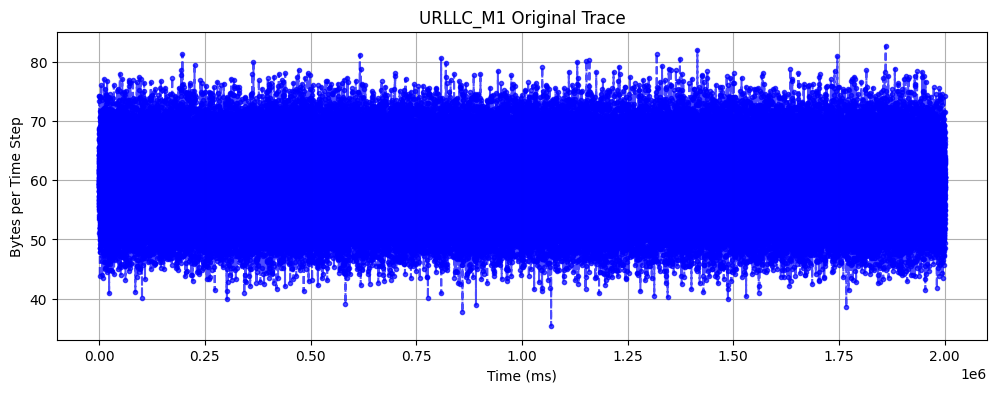

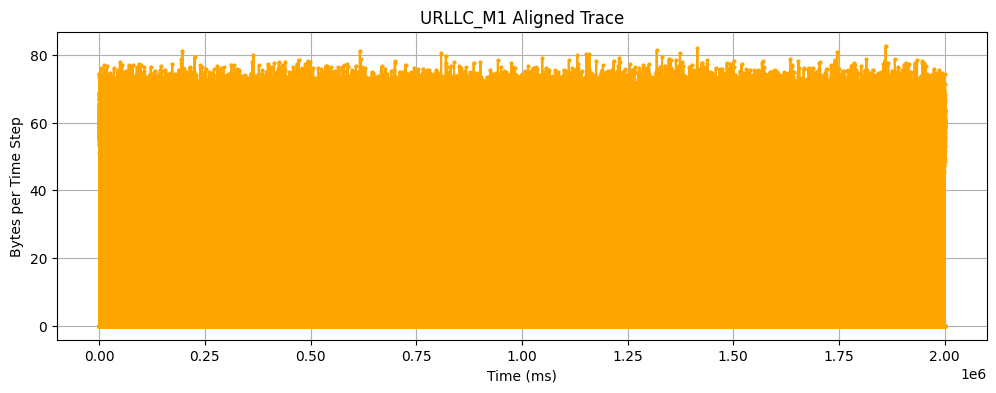

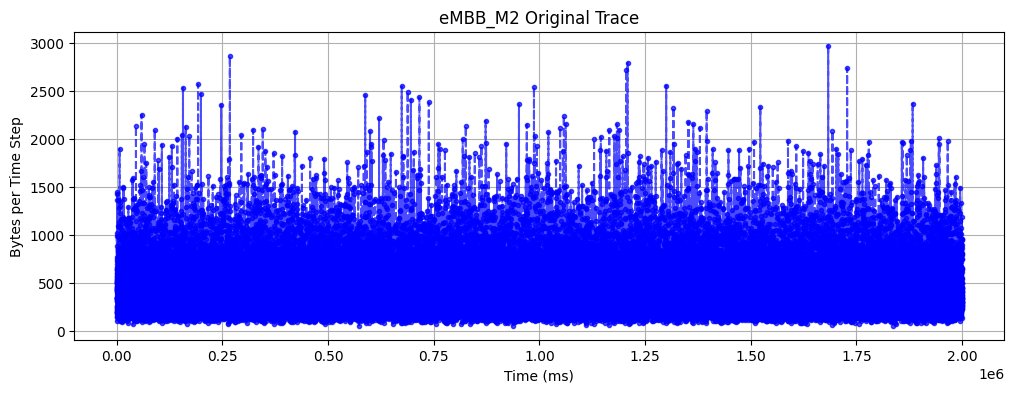

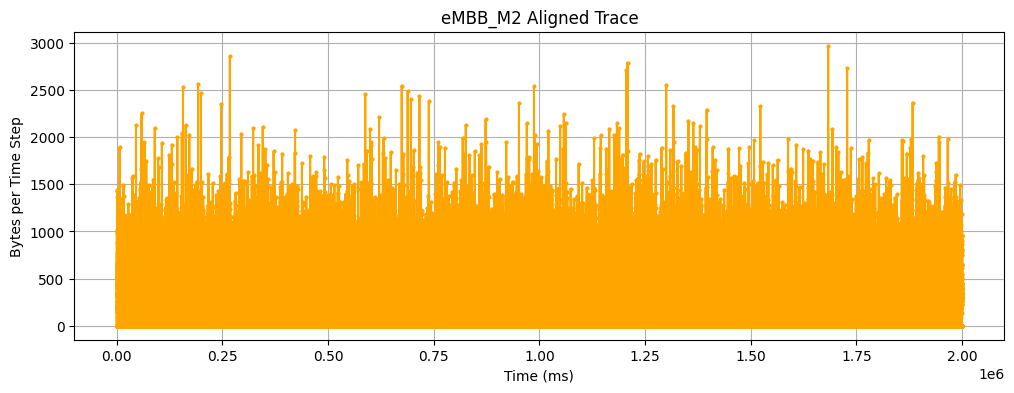

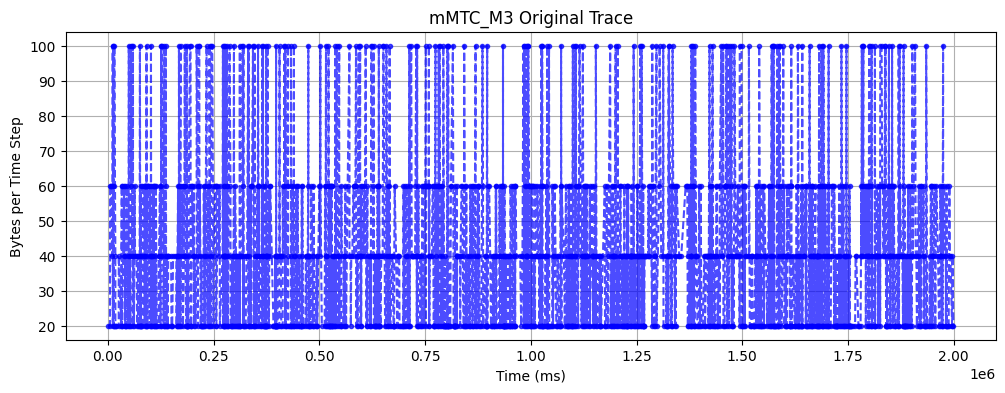

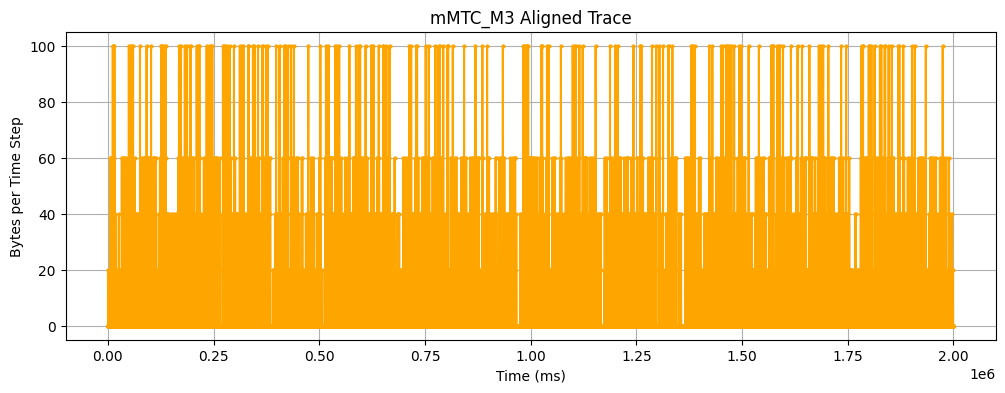

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Base path where your traces are stored
base_path = "./"

# File dictionary
files = {
    "URLLC_M1": {
        "aligned": os.path.join(base_path, "URLLC_M1_aligned_trace.csv"),
        "original": os.path.join(base_path, "URLLC_M1_trace.csv")
    },
    "eMBB_M2": {
        "aligned": os.path.join(base_path, "eMBB_M2_aligned_trace.csv"),
        "original": os.path.join(base_path, "eMBB_M2_trace.csv")
    },
    "mMTC_M3": {
        "aligned": os.path.join(base_path, "mMTC_M3_aligned_trace.csv"),
        "original": os.path.join(base_path, "mMTC_M3_trace.csv")
    }
}

# Loop through machines and plot separately
for machine, paths in files.items():
    # Load CSVs
    df_aligned = pd.read_csv(paths["aligned"])
    df_original = pd.read_csv(paths["original"])

    # Aggregate traffic load per time step
    agg_aligned = df_aligned.groupby("Time")["Length"].sum()
    agg_original = df_original.groupby("Time")["Length"].sum()

    # Original plot
    plt.figure(figsize=(12, 4))
    plt.plot(agg_original.index, agg_original.values, 
             linestyle="--", marker=".", alpha=0.7, color="blue")
    plt.title(f"{machine} Original Trace")
    plt.xlabel("Time (ms)")
    plt.ylabel("Bytes per Time Step")
    plt.grid(True)
    plt.show()

    # Aligned plot
    plt.figure(figsize=(12, 4))
    plt.plot(agg_aligned.index, agg_aligned.values, 
             linestyle="-", marker="o", markersize=2, color="orange")
    plt.title(f"{machine} Aligned Trace")
    plt.xlabel("Time (ms)")
    plt.ylabel("Bytes per Time Step")
    plt.grid(True)
    plt.show()


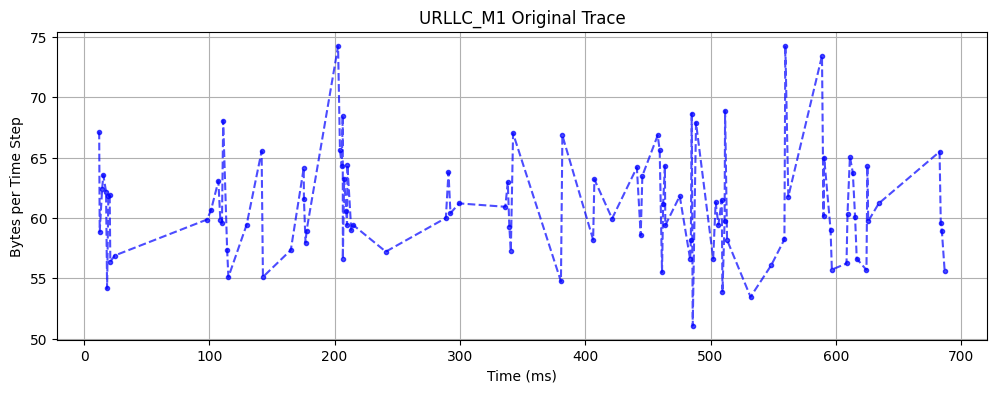

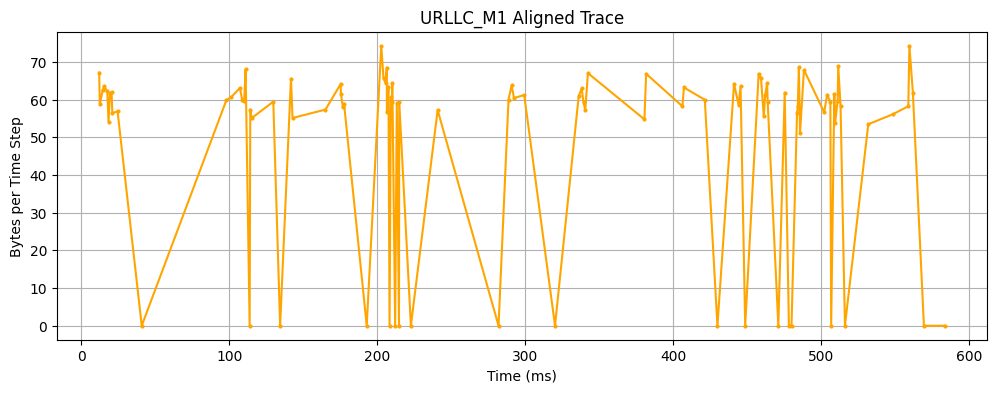

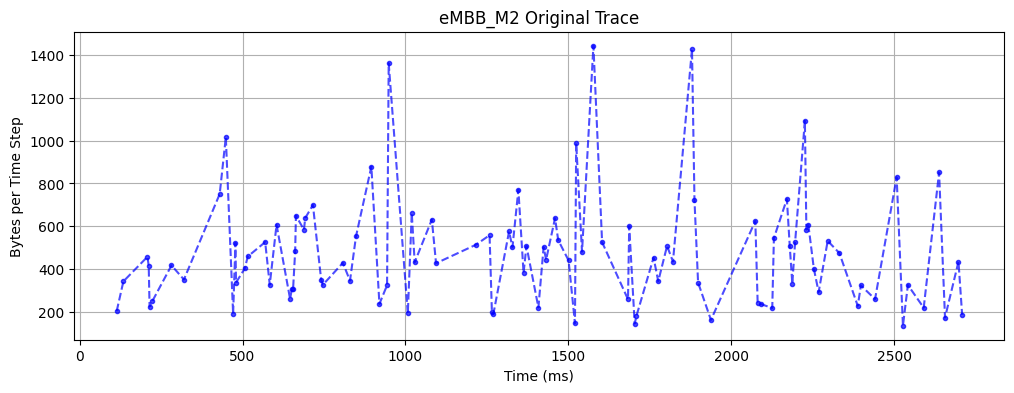

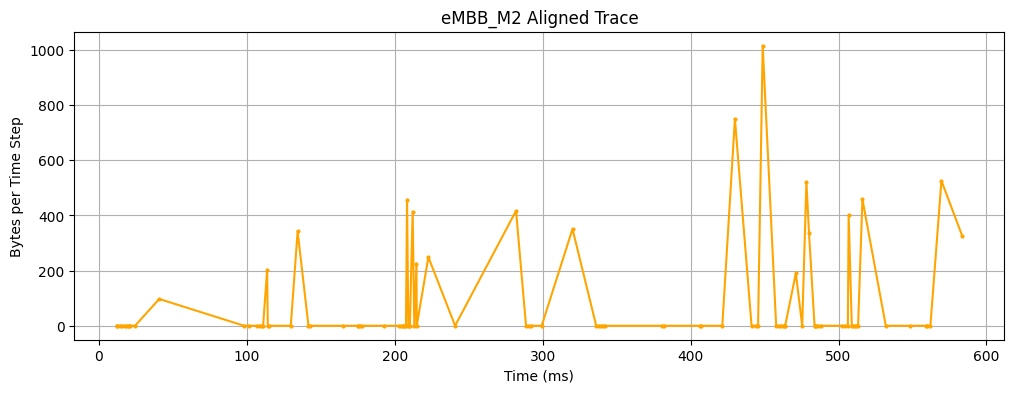

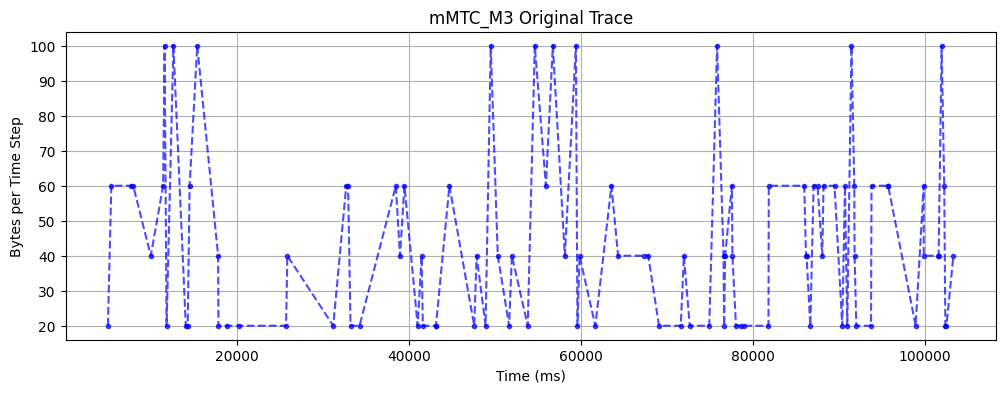

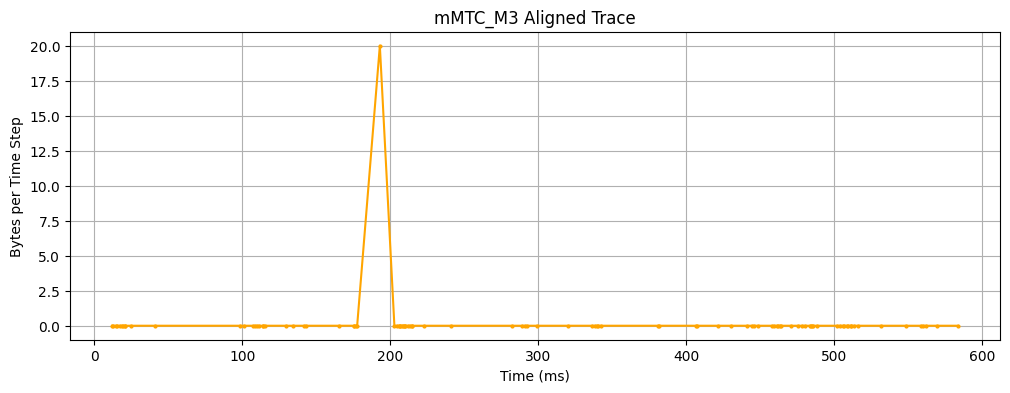

In [5]:
# Loop through machines and plot separately
for machine, paths in files.items():
    # Load CSVs
    df_aligned = pd.read_csv(paths["aligned"])
    df_original = pd.read_csv(paths["original"])

    # Aggregate traffic load per time step
    agg_aligned = df_aligned[1:100].groupby("Time")["Length"].sum()
    agg_original = df_original[1:100].groupby("Time")["Length"].sum()

    # Original plot
    plt.figure(figsize=(12, 4))
    plt.plot(agg_original.index, agg_original.values, 
             linestyle="--", marker=".", alpha=0.7, color="blue")
    plt.title(f"{machine} Original Trace")
    plt.xlabel("Time (ms)")
    plt.ylabel("Bytes per Time Step")
    plt.grid(True)
    plt.show()

    # Aligned plot
    plt.figure(figsize=(12, 4))
    plt.plot(agg_aligned.index, agg_aligned.values, 
             linestyle="-", marker="o", markersize=2, color="orange")
    plt.title(f"{machine} Aligned Trace")
    plt.xlabel("Time (ms)")
    plt.ylabel("Bytes per Time Step")
    plt.grid(True)
    plt.show()

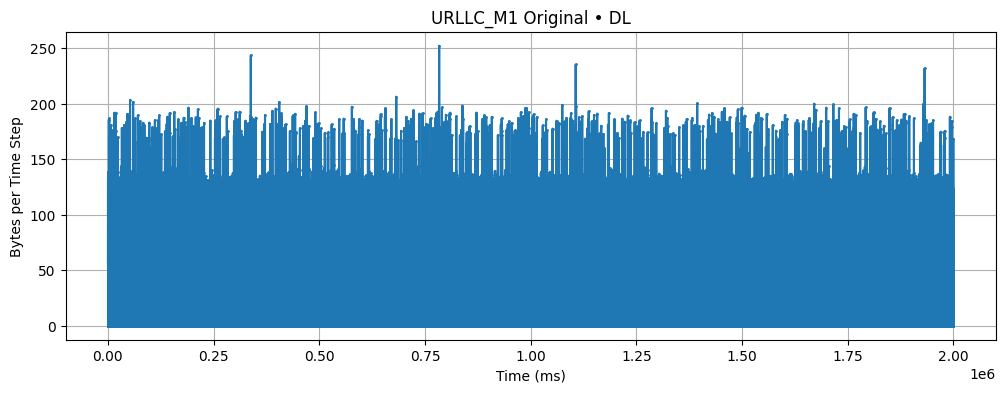

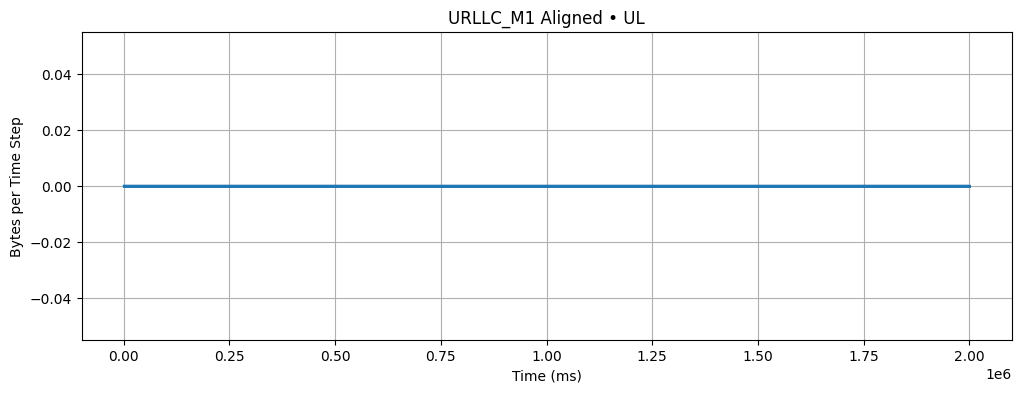

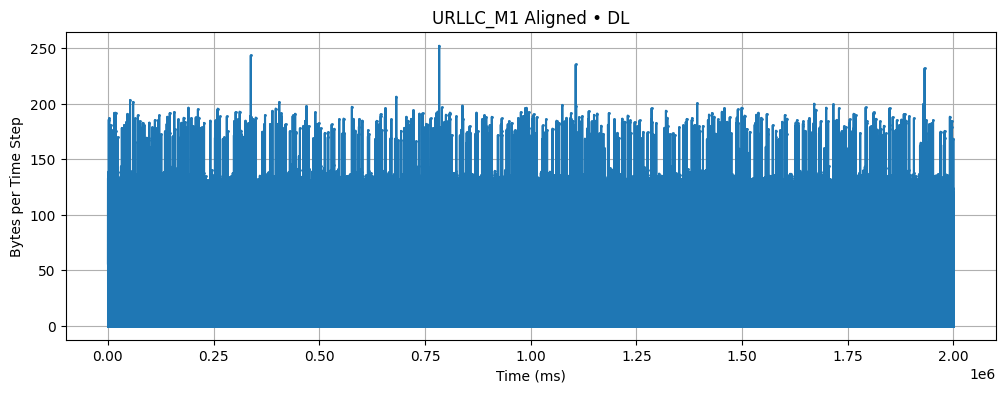

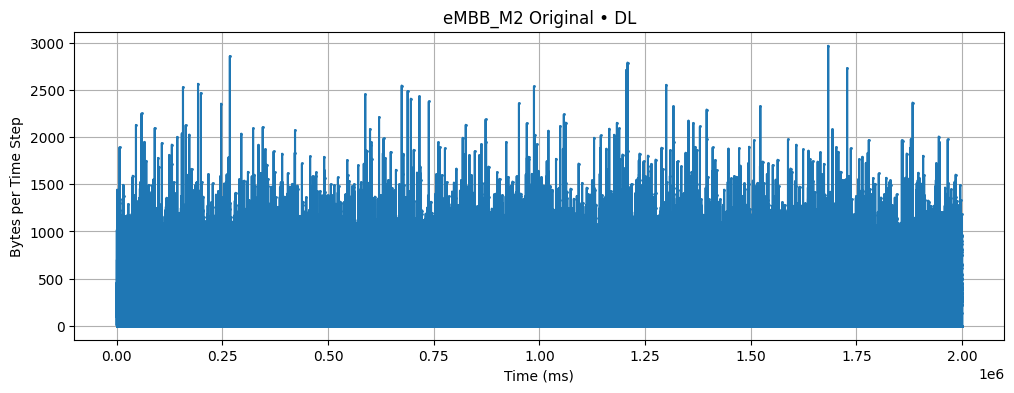

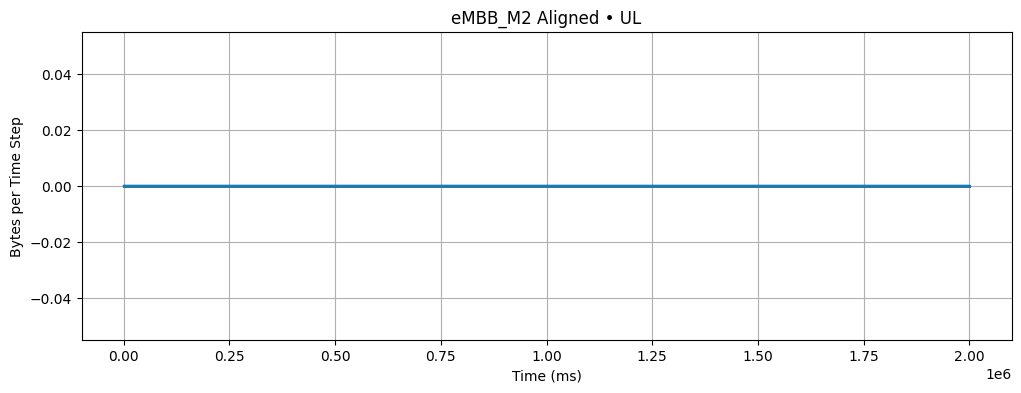

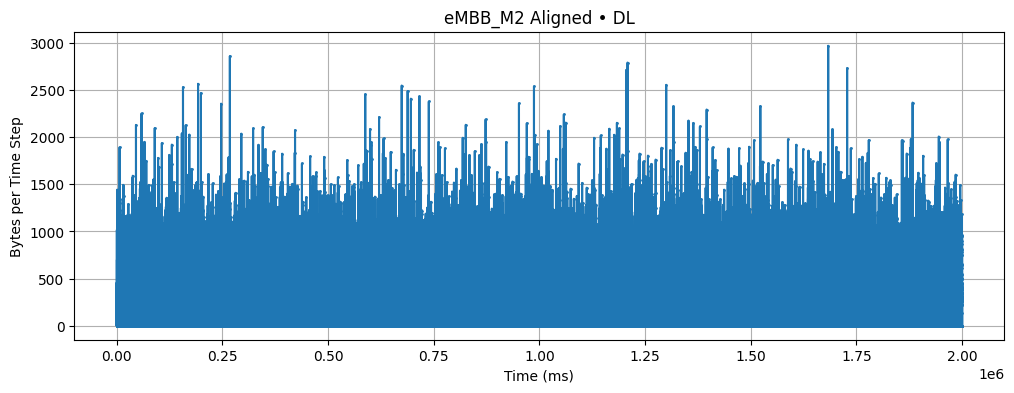

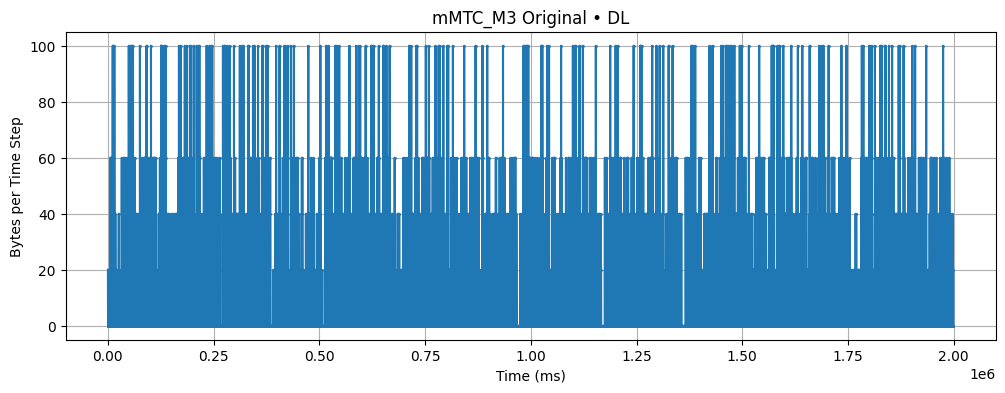

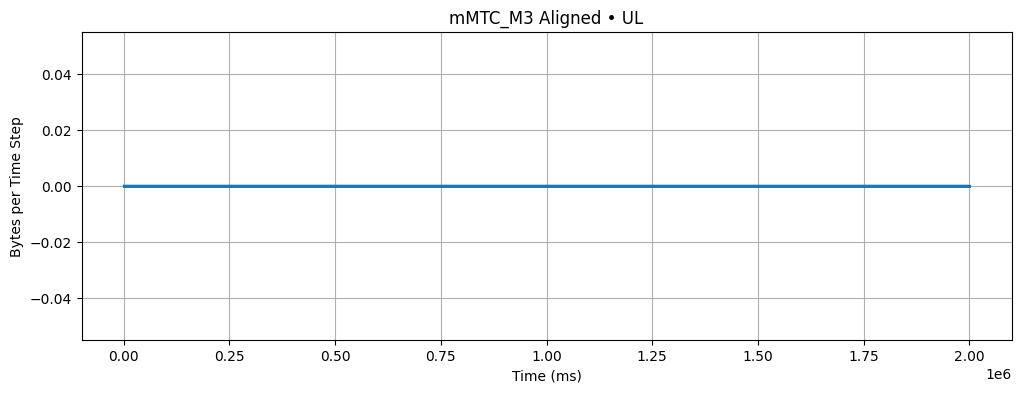

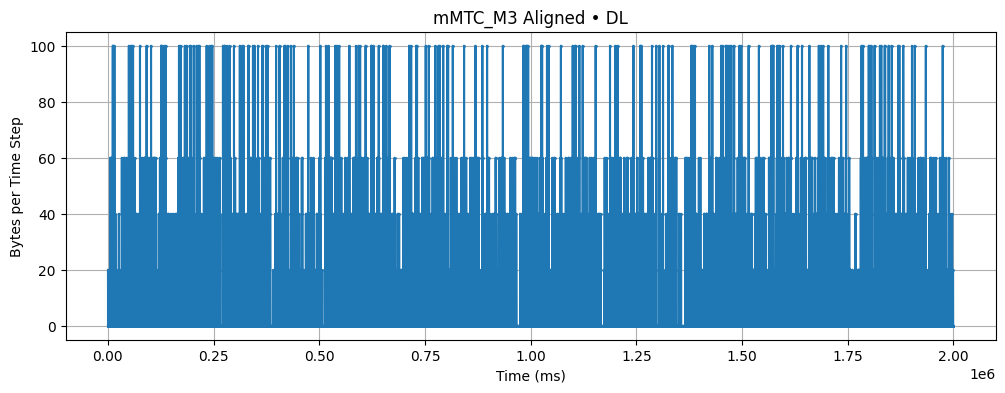

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

base_path = "./"

files = {
    "URLLC_M1": {
        "aligned": os.path.join(base_path, "URLLC_M1_aligned_trace.csv"),
        "original": os.path.join(base_path, "URLLC_M1_trace.csv"),
    },
    "eMBB_M2": {
        "aligned": os.path.join(base_path, "eMBB_M2_aligned_trace.csv"),
        "original": os.path.join(base_path, "eMBB_M2_trace.csv"),
    },
    "mMTC_M3": {
        "aligned": os.path.join(base_path, "mMTC_M3_aligned_trace.csv"),
        "original": os.path.join(base_path, "mMTC_M3_trace.csv"),
    },
}

def make_continuous_series(df: pd.DataFrame, time_col="Time", val_col="Length") -> pd.Series:
    """
    Build a continuous per–time-step series by:
      - rounding times to integer ms
      - summing values per time step
      - reindexing to the full range and filling gaps with 0
    Returns a pandas Series indexed by integer ms.
    """
    if df.empty:
        return pd.Series(dtype=float)

    s = (
        df.assign(t_bin=lambda x: x[time_col].round().astype(int))
          .groupby("t_bin")[val_col].sum()
          .sort_index()
    )
    full_idx = np.arange(s.index.min(), s.index.max() + 1)
    return s.reindex(full_idx, fill_value=0.0)

def plot_len_by_direction_for_machine(df: pd.DataFrame, title_prefix: str):
    """
    Makes two continuous line plots per dataframe:
      - UL bytes per time step
      - DL bytes per time step
    """
    for direction in ["UL", "DL"]:
        sdf = df[df["direction"] == direction].copy()
        series = make_continuous_series(sdf)

        if series.empty:
            continue

        plt.figure(figsize=(12, 4))
        plt.plot(series.index, series.values, linestyle="-", marker=".", markersize=2)
        plt.title(f"{title_prefix} • {direction}")
        plt.xlabel("Time (ms)")
        plt.ylabel("Bytes per Time Step")
        plt.grid(True)
        plt.show()

# ---- main loop: per machine, Original + Aligned, split by UL/DL ----
for machine, paths in files.items():
    df_o = pd.read_csv(paths["original"])
    df_a = pd.read_csv(paths["aligned"])

    # Original (UL & DL as separate continuous lines)
    plot_len_by_direction_for_machine(df_o, f"{machine} Original")

    # Aligned (UL & DL as separate continuous lines)
    plot_len_by_direction_for_machine(df_a, f"{machine} Aligned")


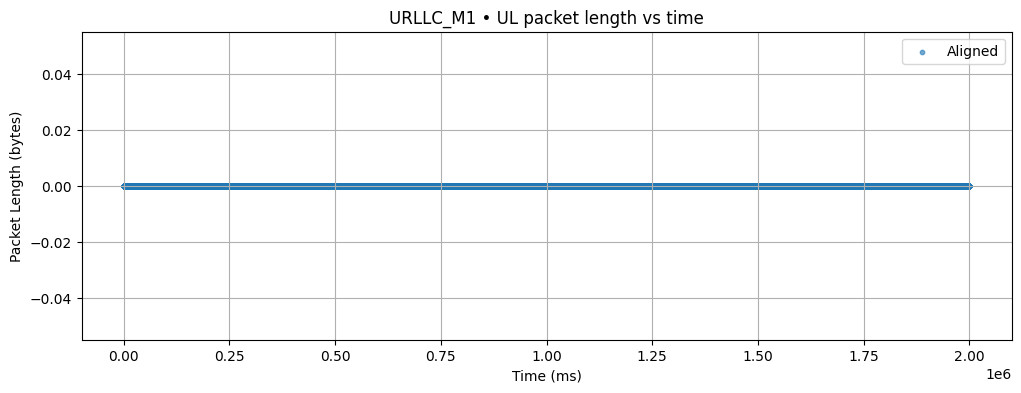

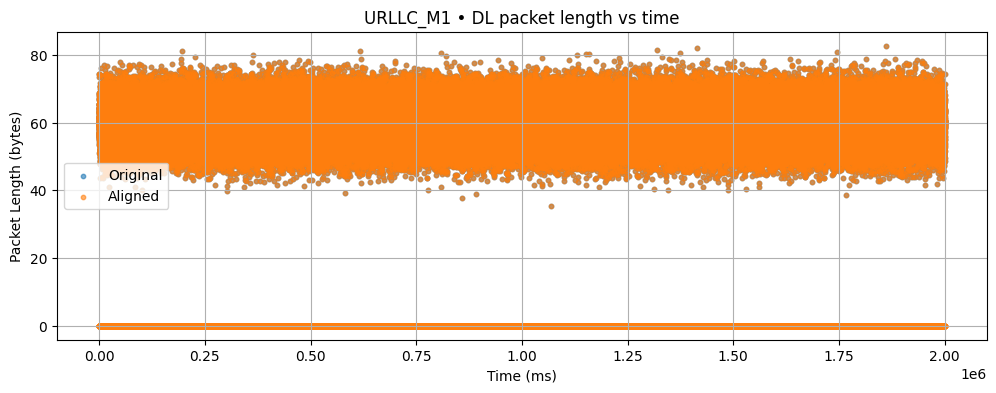

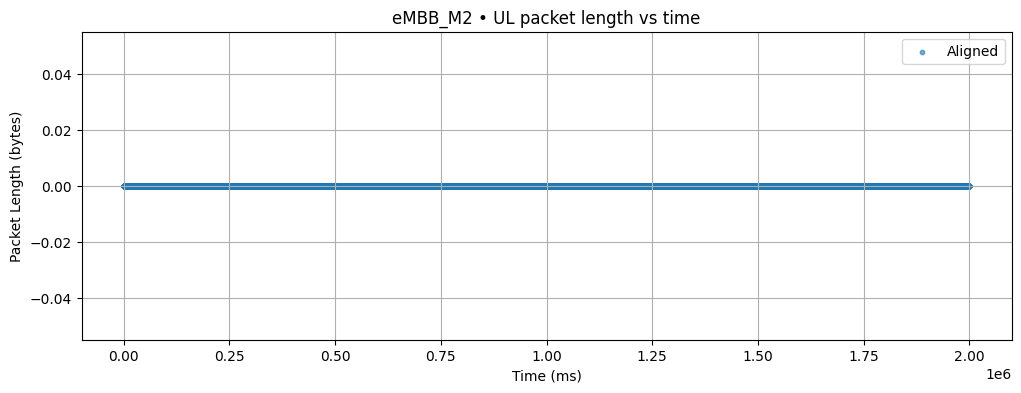

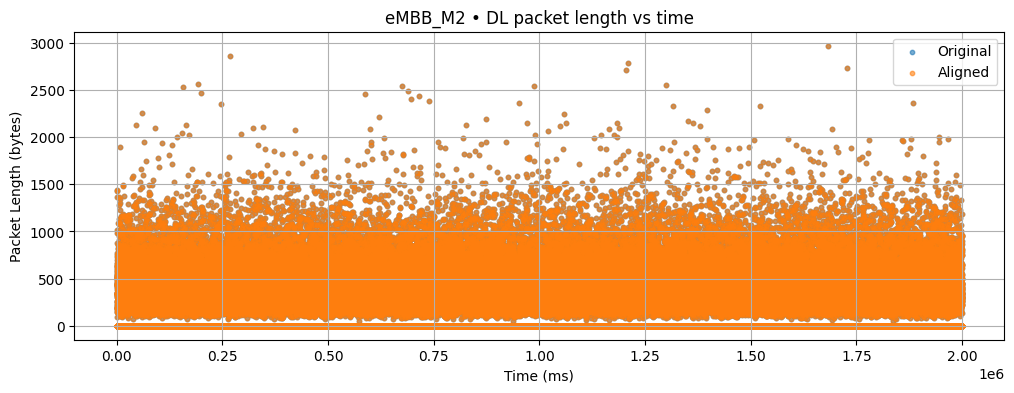

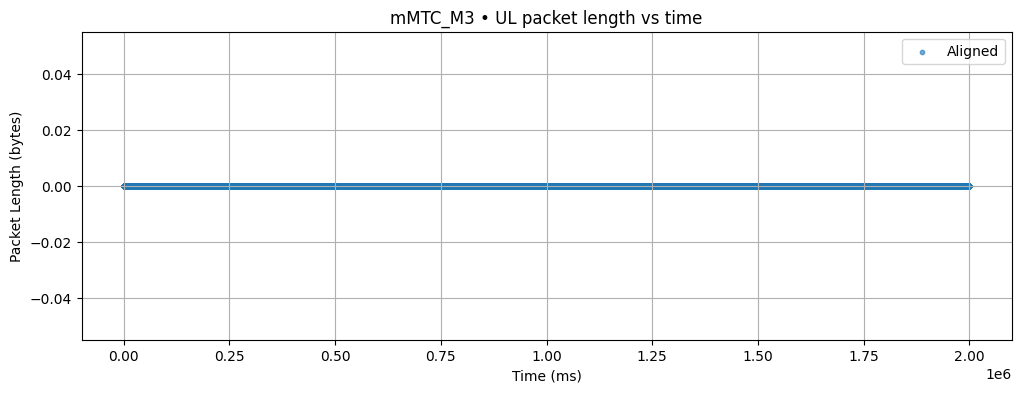

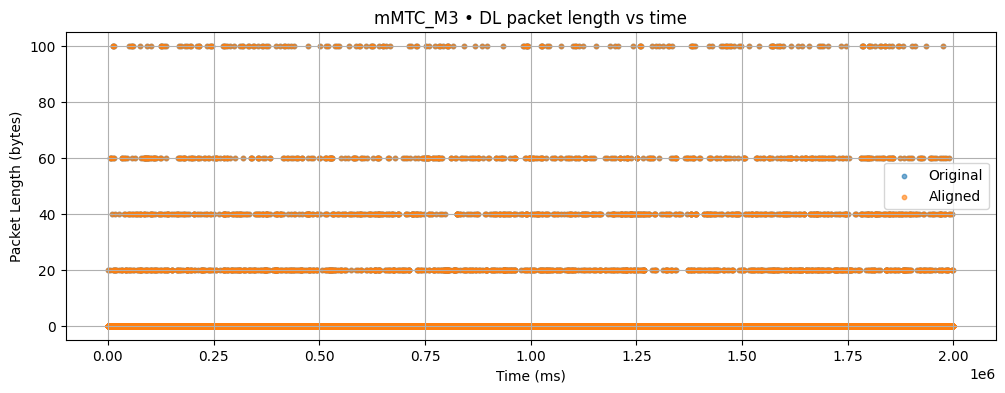

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Base path where your traces are stored
base_path = "./"

# Your file dictionary (same as you shared)
files = {
    "URLLC_M1": {
        "aligned": os.path.join(base_path, "URLLC_M1_aligned_trace.csv"),
        "original": os.path.join(base_path, "URLLC_M1_trace.csv")
    },
    "eMBB_M2": {
        "aligned": os.path.join(base_path, "eMBB_M2_aligned_trace.csv"),
        "original": os.path.join(base_path, "eMBB_M2_trace.csv")
    },
    "mMTC_M3": {
        "aligned": os.path.join(base_path, "mMTC_M3_aligned_trace.csv"),
        "original": os.path.join(base_path, "mMTC_M3_trace.csv")
    }
}

def plot_len_vs_time_by_dir(df_aligned: pd.DataFrame, df_original: pd.DataFrame, machine_label: str):
    # Expect columns: Time, Length, direction (values 'UL'/'DL')
    for direction in ["UL", "DL"]:
        df_o = df_original[df_original["direction"] == direction]
        df_a = df_aligned[df_aligned["direction"] == direction]

        if df_o.empty and df_a.empty:
            # nothing to plot for this direction
            continue

        plt.figure(figsize=(12, 4))
        if not df_o.empty:
            plt.scatter(df_o["Time"], df_o["Length"], s=10, alpha=0.6, label="Original")
        if not df_a.empty:
            plt.scatter(df_a["Time"], df_a["Length"], s=10, alpha=0.6, label="Aligned")

        plt.title(f"{machine_label} • {direction} packet length vs time")
        plt.xlabel("Time (ms)")
        plt.ylabel("Packet Length (bytes)")
        plt.legend()
        plt.grid(True)
        plt.show()

# Loop machines
for machine, paths in files.items():
    df_aligned = pd.read_csv(paths["aligned"])
    df_original = pd.read_csv(paths["original"])

    # Safety check: ensure required columns exist
    missing_cols = {"Time", "Length", "direction"} - set(df_aligned.columns) - set(df_original.columns)
    # (The simple check above is lenient; if you want strict per-file checks, do two separate checks.)

    plot_len_vs_time_by_dir(df_aligned, df_original, machine)
